In [2]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [3]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [4]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [5]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [6]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [7]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [ ]:
# This next line takes an hour on my M1 Mac!

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [7]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [8]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [9]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [10]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [11]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $293.86 Truth: $374.41 Error: $80.55 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $193.81 Truth: $225.11 Error: $31.30 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $209.59 Truth: $61.68 Error: $147.91 SLE: 1.47 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $377.86 Truth: $599.99 Error: $222.13 SLE: 0.21 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $201.31 Truth: $16.99 Error: $184.32 SLE: 5.86 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $58.44 Truth: $31.99 Error: $26.45 SLE: 0.35 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $268.03 Truth: $101.79 Error: $166.24 SLE: 0.93 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $249.99 Truth: $289.00 Error: $39.01 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $312.29 Truth: $635.86 Error: $323.57 SLE: 0.50 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $174.77 Truth: $65.99 Error: $108.78 SLE

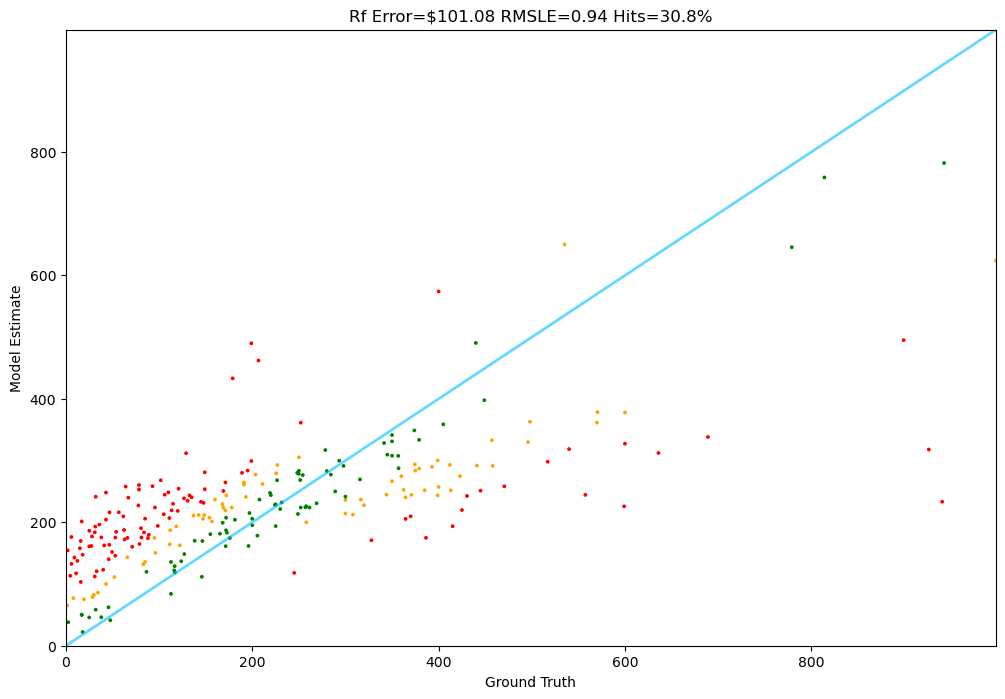

In [26]:
Tester.test(rf, test)

In [10]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [13]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

110.0
159.9
283.0589000000001


In [15]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [37:58<00:00,  9.11s/it]


In [16]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [17]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.28
Frontier: 0.77
RandomForest: -0.06
Min: -0.02
Max: -0.02
Intercept=22.75


In [18]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [8]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [11]:
ensemble.price(product)

145.20487491999398

In [ ]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $337.59 Truth: $374.41 Error: $36.82 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $224.69 Truth: $225.11 Error: $0.42 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $62.96 Truth: $61.68 Error: $1.28 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $474.15 Truth: $599.99 Error: $125.84 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $22.01 Truth: $16.99 Error: $5.02 SLE: 0.06 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $32.60 Truth: $31.99 Error: $0.61 SLE: 0.00 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $73.79 Truth: $101.79 Error: $28.00 SLE: 0.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $343.90 Truth: $289.00 Error: $54.90 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $479.80 Truth: $635.86 Error: $156.06 SLE: 0.08 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $112.82 Truth: $65.99 Error: $46.83 SLE: 0.28 Item

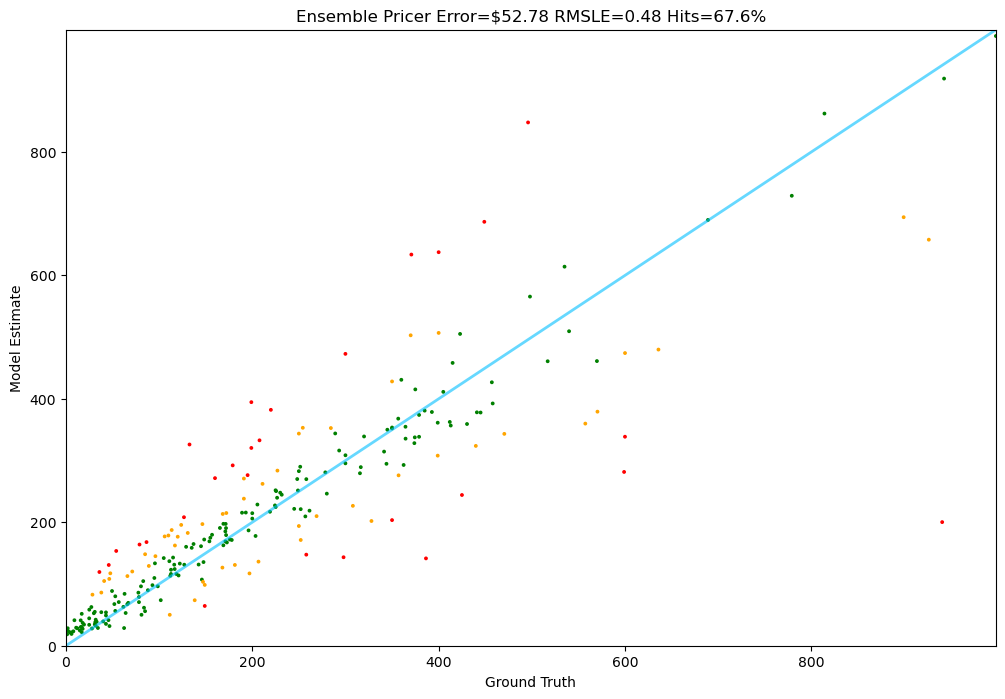

In [22]:
Tester.test(ensemble_pricer, test)